In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import scipy.sparse as scs
from scipy.stats import multinomial
import pathlib as pl
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp
#from mk_doublets import mk_doublets
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, accuracy_score, average_precision_score
from sklearn.neighbors import NearestNeighbors
import umap as um
from sklearn.linear_model import Lasso
import itertools 

from os import listdir
from os.path import isfile, join

from sklearn.model_selection import RepeatedKFold
import sklearn

import random

tfk  = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd  = tfp.distributions

from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

import os
import pickle


In [2]:
def get_dbl_metrics(test, score):
    fig = plt.figure(figsize=(6,3),dpi=100)

    plt.subplot(1,2,1)
    #ROC 
    fpr, tpr, thresholds = metrics.roc_curve(test, score, pos_label=1)
    rauc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr,lw=2, label='ROC curve (area = %0.2f)' % rauc)
    plt.plot([0,1],[0,1],'--',color ='black', lw=1)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC (area = %0.2f)' % rauc)

    plt.subplot(1,2,2)
    # precision recall curve
    precision, recall, thresholds = precision_recall_curve(test, score, pos_label=1)
    prauc = metrics.auc(recall, precision)
    plt.plot(recall, precision, lw=2)
    random=len(test[test==1]) / len(test)
    plt.plot([0, 1], [random, random], linestyle='--', label='random', c='black', lw=1)
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.title("precision vs. recall curve (area = %0.2f)" % prauc)

    plt.tight_layout()
    
    ap = average_precision_score(test, score)
    
    return rauc, prauc, ap


def sim_inflate(X, frac_doublets=None):
    if frac_doublets==None:
        num_doublets = 1 * X.shape[0]
    else:
        num_doublets = int(frac_doublets * X.shape[0])
    
    X1 = np.copy(X)
    X2 = np.copy(X)
    np.random.shuffle(X1)
    np.random.shuffle(X2)
    
    res = X1 + X2 
    
    lib1 = np.sum(X1, axis=1)
    lib2 = np.sum(X2, axis=1)
    
    lib_sze = np.maximum.reduce([lib1,lib2])
    high = np.max(lib_sze)
    
    inflated_sze = np.zeros([len(lib_sze)])
    for i, low in enumerate(lib_sze): 
        inflated_sze[i] = random.choice(lib_sze[lib_sze>=low])
        #inflated_sze[i] = np.random.randint(low, high=high+1, dtype=int)
    
    ls = np.sum(res, axis=1)
    sf = inflated_sze / ls
    res= np.multiply(res.T, sf).T
    
    return res[:num_doublets,:]



In [3]:
def plt_adversarial_loss(hist_list, b1_name, b2_name, m_eps= False):
    
    hist = hist_list[0]
    keysv = list(hist.history.keys())

    y_total = np.array(hist.history['loss'])
    y_rec1 = np.array(hist.history[keysv[1]])
    #y_rec2 = np.array(hist.history[keysv[2]])
    y_btch1 = np.array(hist.history[keysv[2]])
    #y_btch2 = np.array(hist.history[keysv[4]])
    mega_eps = np.array([len(y_total)])
    
    for hist in hist_list[1:]:
        keysv = list(hist.history.keys())

        fig= plt.figure(figsize=(18,6),dpi=300)

        y_total = np.append(y_total, np.array(hist.history['loss']))
        y_rec1 = np.append(y_rec1, np.array(hist.history[keysv[1]]))
        #y_rec2 = np.append(y_rec2, np.array(hist.history[keysv[2]]))
        y_btch1 = np.append(y_btch1, np.array(hist.history[keysv[2]]))
        #y_btch2 = np.append(y_btch2, np.array(hist.history[keysv[4]]))
        print()
        mega_eps = np.append(mega_eps, np.array([mega_eps[-1] + len(hist.history['loss'])]))

    print(mega_eps)
        
    fig= plt.figure(figsize=(18,6),dpi=300)
    
    x = np.arange(len(y_total))
    plt.subplot(2,4,1)
    plt.plot(x, y_total, label = 'loss')
    if(m_eps):
        for ep in mega_eps:
            plt.axvline(x=ep)
    plt.title('loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('total loss')

    plt.subplot(2,4,2)
    plt.plot(x, y_rec1, label = b1_name)
    #plt.plot(x, y_rec2, label = b2_name)
    if(m_eps):
        for ep in mega_eps:
            plt.axvline(x=ep)
    plt.title('reconstruction loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')

    plt.subplot(2,4,3)
    plt.plot(x, y_btch1, label = b1_name)
    #plt.plot(x, y_btch2, label = b2_name)
    if(m_eps):
        for ep in mega_eps:
            plt.axvline(x=ep)
    plt.title('batch loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')

    plt.tight_layout()

In [4]:
def plt_loss(hist):
    x = np.arange(len(hist.history['loss']))
    keysv = list(hist.history.keys())
    
    fig, ax = plt.subplots(nrows=1, ncols=len(keysv), figsize=(6*len(keysv), 6))

    for i,key in enumerate(keysv):

        y = np.array(hist.history[key])
        ax[i].plot(x, y, label = key)
        ax[i].set_xlabel('epoch')
        ax[i].set_ylabel('loss')
        ax[i].set_title(key)
    


In [5]:
def define_classifier(ngens): #try put in batch norm
    classifier = tfk.Sequential([
        tfkl.InputLayer(input_shape=[ngens]),
        #tf.keras.layers.Dense(12, activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.3),
        tf.keras.layers.Dense(12, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.3),
        tf.keras.layers.Dense(12, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.3),
        tf.keras.layers.Dense(12, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.3),
        tf.keras.layers.Dense(12, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.3),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    model = tfk.Model(inputs=classifier.inputs,
                      outputs=classifier.outputs[0])
    
    model.compile(optimizer = tf.optimizers.Adam(learning_rate=1e-3),
                  loss = 'binary_crossentropy')
    
    return model



In [6]:
def define_vae2(enc_sze, ngens, lam=1):
    prior = tfd.Independent(tfd.Normal(loc=tf.zeros(enc_sze), scale=1),
            reinterpreted_batch_ndims=1)

    encoder = tfk.Sequential([
        tfkl.InputLayer(input_shape=[ngens]),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.3),
        tfkl.Dense(tfpl.IndependentNormal.params_size(enc_sze), activation=None),
        tfpl.IndependentNormal(
            enc_sze,
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior))
    ], name='encoder')

    decoder = tfk.Sequential([
        tfkl.InputLayer(input_shape=[enc_sze]),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.3),
        tfkl.Dense(tfpl.IndependentNormal.params_size(ngens), activation=None),
        tfpl.IndependentNormal(ngens)
    ], name='decoder')
    
    decoder2 = tfk.Sequential([
        tfkl.InputLayer(input_shape=[enc_sze]),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.3),
        tfkl.Dense(tfpl.IndependentNormal.params_size(ngens), activation=None),
        tfpl.IndependentNormal(ngens)
    ], name='decoder2')

    encoder2 = tfk.Sequential([
        tfkl.InputLayer(input_shape=[ngens]),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.3),
        tfkl.Dense(tfpl.IndependentNormal.params_size(enc_sze), activation=None),
        tfpl.IndependentNormal(
            enc_sze,
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior))
    ], name='encoder2')
    

    IPT1    = tfk.Input(shape = ngens)
    IPT2    = tfk.Input(shape = ngens)
    z       = encoder(IPT1)
    z2      = encoder2(IPT2)
    OPT1    = decoder(z)
    OPT2    = decoder2(z2)
    
    model = tfk.Model(inputs=[IPT1,
                              IPT2],
                      outputs=[OPT1,
                               OPT2])
    
    def nll(x, rv_x): 
        tmp = rv_x.log_prob(x)
        return -tf.math.reduce_sum(tmp, axis=-1)
    
    model.compile(optimizer = tf.optimizers.Adam(learning_rate=1e-3),
                  loss=[nll,nll],loss_weights=[1,1])
    
    return model

def define_vae3(enc_sze, ngens, lam=1):
    prior = tfd.Independent(tfd.Normal(loc=tf.zeros(enc_sze), scale=1),
            reinterpreted_batch_ndims=1)

    encoder = tfk.Sequential([
        tfkl.InputLayer(input_shape=[ngens]),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.3),
        tfkl.Dense(tfpl.IndependentNormal.params_size(enc_sze), activation=None),
        tfpl.IndependentNormal(
            enc_sze,
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior))
    ], name='encoder')

    decoder = tfk.Sequential([
        tfkl.InputLayer(input_shape=[enc_sze]),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.3),
        tfkl.Dense(tfpl.IndependentNormal.params_size(ngens), activation=None),
        tfpl.IndependentNormal(ngens)
    ], name='decoder')
    
    decoder2 = tfk.Sequential([
        tfkl.InputLayer(input_shape=[enc_sze]),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.3),
        tfkl.Dense(tfpl.IndependentNormal.params_size(ngens), activation=None),
        tfpl.IndependentNormal(ngens)
    ], name='decoder2')

    encoder2 = tfk.Sequential([
        tfkl.InputLayer(input_shape=[ngens]),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.3),
        tfkl.Dense(tfpl.IndependentNormal.params_size(enc_sze), activation=None),
        tfpl.IndependentNormal(
            enc_sze,
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior))
    ], name='encoder2')
    
    @tf.custom_gradient
    def grad_reverse(x):
        y = tf.identity(x)
        def custom_grad(dy):
            return -1.0*lam*dy
        return y, custom_grad

    class GradReverse(tf.keras.layers.Layer):
        def __init__(self):
            super().__init__()

        def call(self, x):
            return grad_reverse(x)

    discriminator = tfk.Sequential([
        tfkl.InputLayer(input_shape=[enc_sze]),
        #tf.keras.layers.Dense(12, activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        GradReverse(),
        #tf.keras.layers.Dropout(rate=0.3),
        #tf.keras.layers.Dense(12, activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Dropout(rate=0.3),
        #tf.keras.layers.Dense(12, activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Dropout(rate=0.3),
        #tf.keras.layers.Dense(12, activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Dropout(rate=0.3),
        tf.keras.layers.Dense(12, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.3),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ], name='discriminator')

    IPT1    = tfk.Input(shape = ngens)
    IPT2    = tfk.Input(shape = ngens)
    z       = encoder(IPT1)
    z2      = encoder2(IPT2)
    OPT1    = decoder(z)
    OPT2    = decoder2(z2)
    #OPT1    = discriminator(z)
    #OPT2    = discriminator(z2)
    #OPT3    = decoder2(z2)
    
    #model = tfk.Model(inputs=encoder.inputs,
    #              outputs=decoder(encoder.outputs[0]))
    
    model = tfk.Model(inputs=[IPT1,
                              IPT2],
                      outputs=[OPT1,
                               OPT2])
    
    def nll(x, rv_x): 
        tmp = rv_x.log_prob(x)
        return -tf.math.reduce_sum(tmp, axis=-1)
    
    model.compile(optimizer = tf.optimizers.Adam(learning_rate=1e-3),
                  loss=[nll,nll],loss_weights=[1,1])

    #print(model.summary())
    #print(model.get_layer(name='encoder'))
    
    return model


def define_vae4(enc_sze, ngens, lam=1):
    prior = tfd.Independent(tfd.Normal(loc=tf.zeros(enc_sze), scale=1),
            reinterpreted_batch_ndims=1)

    encoder = tfk.Sequential([
        tfkl.InputLayer(input_shape=[ngens]),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.3),
        tfkl.Dense(tfpl.IndependentNormal.params_size(enc_sze), activation=None),
        tfpl.IndependentNormal(
            enc_sze,
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior))
    ], name='encoder')

    decoder = tfk.Sequential([
        tfkl.InputLayer(input_shape=[enc_sze]),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.3),
        tfkl.Dense(tfpl.IndependentNormal.params_size(ngens), activation=None),
        tfpl.IndependentNormal(ngens)
    ], name='decoder')
    
    @tf.custom_gradient
    def grad_reverse(x):
        y = tf.identity(x)
        def custom_grad(dy):
            return -1.0*lam*dy
        return y, custom_grad

    class GradReverse(tf.keras.layers.Layer):
        def __init__(self):
            super().__init__()

        def call(self, x):
            return grad_reverse(x)

    discriminator = tfk.Sequential([
        tfkl.InputLayer(input_shape=[enc_sze]),
        #GradReverse(),
        tf.keras.layers.Dense(12, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.3),
        tf.keras.layers.Dense(12, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.3),
        tf.keras.layers.Dense(12, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.3),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ], name='discriminator')

    IPT     = tfk.Input(shape = ngens)
    z       = encoder(IPT)
    OPT1    = decoder(z)
    OPT2    = discriminator(z)
    
    model = tfk.Model(inputs=[IPT],
                      outputs=[OPT1,
                               OPT2])
    
    def nll(x, rv_x): 
        tmp = rv_x.log_prob(x)
        return -tf.math.reduce_sum(tmp, axis=-1)
    
    model.compile(optimizer = tf.optimizers.Adam(learning_rate=1e-5),
                  loss=[nll,'binary_crossentropy'],loss_weights=[0.01,-1])
    
    return model


def define_vae(enc_sze, ngens, lam=1):
    prior = tfd.Independent(tfd.Normal(loc=tf.zeros(enc_sze), scale=1),
            reinterpreted_batch_ndims=1)

    encoder = tfk.Sequential([
        tfkl.InputLayer(input_shape=[ngens]),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.3),
        tfkl.Dense(tfpl.IndependentNormal.params_size(enc_sze), activation=None),
        tfpl.IndependentNormal(
            enc_sze,
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior))
    ], name='encoder')

    decoder = tfk.Sequential([
        tfkl.InputLayer(input_shape=[enc_sze]),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.3),
        tfkl.Dense(tfpl.IndependentNormal.params_size(ngens), activation=None),
        tfpl.IndependentNormal(ngens)
    ], name='decoder')

    IPT    = tfk.Input(shape = ngens)
    z       = encoder(IPT)
    OPT     = decoder(z)
    
    #model = tfk.Model(inputs=encoder.inputs,
    #              outputs=decoder(encoder.outputs[0]))
    
    model = tfk.Model(inputs=[IPT],
                outputs=[OPT])
    
    def nll(x, rv_x): 
        tmp = rv_x.log_prob(x)
        return -tf.math.reduce_sum(tmp, axis=-1)
    
    model.compile(optimizer = tf.optimizers.Adam(learning_rate=1e-3),
                  loss=[nll])
    
    return model


In [18]:
for i in range(len(files)):
    path = '../data/npy_objs/'
    files = [f for f in listdir(path) if (isfile(join(path, f)) & (f[-11:] == '_counts.npy'))]
    file = files[i]


    N    = 1
    k    = 10
    eps  = 100#40#100
    cls_eps =100 # early stopping
    lam = 1
    dist = 'gaussian'

    encode    = True
    load_data = True

    simulate_doubs = True

    classification_method = 'none'#PU classifier knn PU_knn

    projections = True
    save_figs = True

    pca = PCA(n_components=32)

    knn_features = True


    if(load_data):
        data_name = file[:-11]

        print(data_name)
        path = '../data/npy_objs/' + data_name + '_counts.npy'
        ano_path  = '../data/npy_objs/' + data_name + '_meta_data.csv'
        umap_path = '../data/npy_objs/' + data_name + '_umap.npy'
        save_path = '../results_PU_doublet/doublet_btch_corr/no_alignment_one_vae/' + data_name + '_'

        #- READ IN COUNTS
        cnts_file = pl.Path(path)
        if cnts_file.exists():
            dat = np.load(cnts_file)#csr sparse matrix format
        else:
            print('does not exist')

        dat = scs.csr_matrix(dat).toarray()

        #- READ IN BARCODE ANNOTATIONS
        ano = pd.read_csv(ano_path)
        true = (np.array(ano.doublet_true_labels=='doublet') | np.array(ano.doublet_true_labels=='Doublet'))


        #- HVGs
        col_v  = dat.var(axis=0)#gene varience
        ngens  = 2000

        #sort the variances
        hvg    = np.argpartition(col_v,-ngens)[-ngens:] #- negative because of increasing sort
        dat_c  = dat[:,hvg] #data_c sliced to max variable genes 


    if (simulate_doubs):

        dbl_path  = '../data/npy_objs/' + data_name + '_sim_dbls.npy'
        dbl_umap_path = '../data/npy_objs/' + data_name + '_dbl_umap.npy'
        dbl_file = pl.Path(dbl_path)
        if dbl_file.exists():
            P = np.load(dbl_file)#csr sparse matrix format
        else:
            print('simulating doublets')

            P = sim_inflate(dat, frac_doublets=1)
            np.save(dbl_path, P)
            print(P.shape)

        U = dat



HEK-HMEC-MULTI
simulating doublets
(10641, 23982)
pbmc-1A-dm
simulating doublets
(3298, 15170)
cline-ch
hm-12k
simulating doublets
(12820, 15106)
hm-6k
simulating doublets
(6806, 15080)
HMEC-orig-MULTI
simulating doublets
(26426, 24199)
HMEC-rep-MULTI
simulating doublets
(10580, 17473)
J293t-dm
simulating doublets
(500, 16374)
mkidney-ch
nuc-MULTI
pbmc-1B-dm
simulating doublets
(3790, 15143)
pbmc-1C-dm
simulating doublets
(5270, 15865)
pbmc-2ctrl-dm
simulating doublets
(13913, 17584)
pbmc-2stim-dm
simulating doublets
(13916, 17315)
pbmc-ch
simulating doublets
(15272, 21639)
pdx-MULTI
simulating doublets
(10296, 14025)
hgmm


In [17]:
path = '../data/npy_objs/'
files = [f for f in listdir(path) if (isfile(join(path, f)) & (f[-11:] == '_counts.npy'))]
file = files[0]
file

'pbmc-1A-dm_counts.npy'

In [13]:
files

['HEK-HMEC-MULTI_counts.npy',
 'pbmc-1A-dm_counts.npy',
 'cline-ch_counts.npy',
 'hm-12k_counts.npy',
 'hm-6k_counts.npy',
 'HMEC-orig-MULTI_counts.npy',
 'HMEC-rep-MULTI_counts.npy',
 'J293t-dm_counts.npy',
 'mkidney-ch_counts.npy',
 'nuc-MULTI_counts.npy',
 'pbmc-1B-dm_counts.npy',
 'pbmc-1C-dm_counts.npy',
 'pbmc-2ctrl-dm_counts.npy',
 'pbmc-2stim-dm_counts.npy',
 'pbmc-ch_counts.npy',
 'pdx-MULTI_counts.npy',
 'hgmm_counts.npy']

In [14]:
N    = 1
k    = 10
eps  = 100#40#100
cls_eps =100 # early stopping
lam = 1
dist = 'gaussian'

encode    = True
load_data = True

simulate_doubs = True

classification_method = 'none'#PU classifier knn PU_knn

projections = True
save_figs = True

pca = PCA(n_components=32)

knn_features = True


In [15]:
if(load_data):
    data_name = file[:-11]

    print(data_name)
    path = '../data/npy_objs/' + data_name + '_counts.npy'
    ano_path  = '../data/npy_objs/' + data_name + '_meta_data.csv'
    umap_path = '../data/npy_objs/' + data_name + '_umap.npy'
    save_path = '../results_PU_doublet/doublet_btch_corr/no_alignment_one_vae/' + data_name + '_'

    #- READ IN COUNTS
    cnts_file = pl.Path(path)
    if cnts_file.exists():
        dat = np.load(cnts_file)#csr sparse matrix format
    else:
        print('does not exist')

    dat = scs.csr_matrix(dat).toarray()

    #- READ IN BARCODE ANNOTATIONS
    ano = pd.read_csv(ano_path)
    true = (np.array(ano.doublet_true_labels=='doublet') | np.array(ano.doublet_true_labels=='Doublet'))


    #- HVGs
    col_v  = dat.var(axis=0)#gene varience
    ngens  = 2000

    #sort the variances
    hvg    = np.argpartition(col_v,-ngens)[-ngens:] #- negative because of increasing sort
    dat_c  = dat[:,hvg] #data_c sliced to max variable genes 



nuc-MULTI


In [16]:
if (simulate_doubs):

    dbl_path  = '../data/npy_objs/' + data_name + '_sim_dbls.npy'
    dbl_umap_path = '../data/npy_objs/' + data_name + '_dbl_umap.npy'
    dbl_file = pl.Path(dbl_path)
    if dbl_file.exists():
        P = np.load(dbl_file)#csr sparse matrix format
    else:
        print('simulating doublets')

        P = sim_inflate(dat, frac_doublets=1)
        np.save(dbl_path, P)
        print(P.shape)

    U = dat

            
    #umap_file = pl.Path(dbl_umap_path)
    #if umap_file.exists():
    #    proj2 = np.load(umap_file)#csr sparse matrix format
    #else:
    #    proj2 = um.UMAP(n_neighbors=7).fit_transform(np.vstack([U, P]))
    #    np.save(dbl_umap_path, proj2)

    #fig, ax = plt.subplots()
    #col = np.concatenate([true, np.ones([P.shape[0]])+1])
    #scatter = ax.scatter(proj2[:,0],proj2[:,1], c=col, s=0.1, alpha=0.5)
    #legend = ax.legend(*scatter.legend_elements(), title= 'Cell Call')
    #plt.title(data_name + ' origional UMAP')
    #ax.add_artist(legend)
    #plt.title(data_name + ' observed plus doublets')
    #plt.show()

simulating doublets
(5578, 21490)


In [143]:

#if (simulate_doubs):
    #P, prop, multi = simulate_multiplets(dat.toarray()[:,hvg], frac_doublets=1/10, tripplets=False)

#    P = sim_inflate(dat_c, frac_doublets=1)

#    U = dat_c

#    if(projections):
#        proj2 = um.UMAP(n_neighbors=7).fit_transform(np.vstack([U, P]))
#        fig, ax = plt.subplots()
#        col = np.concatenate([true, np.ones([P.shape[0]])+1])
#        scatter = ax.scatter(proj2[:,0],proj2[:,1], c=col, s=0.1, alpha=0.5)
#        legend = ax.legend(*scatter.legend_elements(), title="Cell Call")
#        ax.add_artist(legend)
#        plt.title(data_name + ' observed plus doublets')
#        plt.show()

#X = np.vstack([U, P])

#Y = np.concatenate([np.zeros([U.shape[0]]),
#                   np.ones([P.shape[0]])])

#lib_sizes = np.sum(X, axis=1)


In [144]:
U = U[:,hvg]
P = P[:,hvg]

#- log-transform
#X = np.log2(X+1)
U = np.log2(U+1)
P = np.log2(np.round(P)+1)


#- MEAN CENTER EACH CELL
#X  = (X.transpose() - X.mean(axis=1)).transpose()
U  = (U.transpose() - U.mean(axis=1)).transpose()
P  = (P.transpose() - P.mean(axis=1)).transpose()

<Figure size 432x288 with 0 Axes>

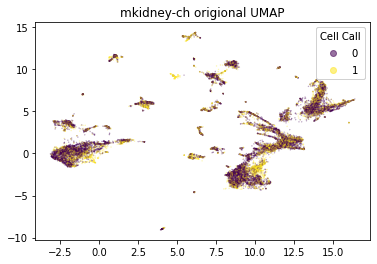

In [145]:
#MAKE PROJECTION IF IT DOES NOT ALREADY EXIST
umap_file = pl.Path(umap_path)
if umap_file.exists():
    proj = np.load(umap_file)#csr sparse matrix format
else:
    proj = um.UMAP(n_neighbors=7).fit_transform(dat_c)
    np.save(umap_path, proj)

plt.figure(30)
fig, ax = plt.subplots()
scatter = ax.scatter(proj[:,0],proj[:,1], c=true, s=0.1, alpha=0.5)
legend = ax.legend(*scatter.legend_elements(), title= 'Cell Call')
plt.title(data_name + ' origional UMAP')
ax.add_artist(legend)
plt.show()

#ENCODE DATA
enc_sze = 32


In [146]:

#generator = vae_model.get_layer(name='generator')
#discriminator = vae_model.get_layer(name='discriminator')

if (False):
    vae_model  = define_vae2(enc_sze, ngens, lam=lam)

    hist = vae_model.fit(x=[U,P],y=[U,P],epochs=eps)
    encoder = vae_model.get_layer(name='encoder')
    decoder = vae_model.get_layer(name='decoder')
    encoder_sim = vae_model.get_layer(name='encoder2')
    decoder_sim = vae_model.get_layer(name='decoder2')

    z_real = np.array(tf.convert_to_tensor(encoder(U)))
    z_sim  = np.array(tf.convert_to_tensor(encoder_sim(U)))
    z_all  = np.vstack([z_real,z_sim])

if (False):
    
    vae_model  = define_vae4(enc_sze, ngens, lam=lam)

    X = np.vstack([U,P])
    # CHEAT MODE
    #Y = np.concatenate([true, np.ones([P.shape[0]])])
    Y = np.concatenate([np.zeros([U.shape[0]]), np.ones([P.shape[0]])])
    
    hist = vae_model.fit(x=X,y=[X,Y],epochs=eps)
    encoder = vae_model.get_layer(name='encoder')
    decoder = vae_model.get_layer(name='decoder')
    discriminator = vae_model.get_layer(name='discriminator')  

    z_all   = np.array(tf.convert_to_tensor(encoder(X)))
    z_real  = z_all[:U.shape[0],:]
    z_sim   = z_all[U.shape[0]:,:]




In [147]:
X = np.vstack([U, P])

Y = np.concatenate([np.zeros([U.shape[0]]),
                   np.ones([P.shape[0]])])

In [148]:
if (True):
    prior = tfd.Independent(tfd.Normal(loc=tf.zeros(enc_sze), scale=1),
            reinterpreted_batch_ndims=1)

    encoder = tfk.Sequential([
        tfkl.InputLayer(input_shape=[ngens]),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.3),
        tfkl.Dense(tfpl.IndependentNormal.params_size(enc_sze), activation=None),
        tfpl.IndependentNormal(
            enc_sze)#,
            #activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=1))
    ], name='encoder')

    decoder = tfk.Sequential([
        tfkl.InputLayer(input_shape=[enc_sze]),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.3),
        tfkl.Dense(tfpl.IndependentNormal.params_size(ngens), activation=None),
        tfpl.IndependentNormal(ngens)
    ], name='decoder')


    discriminator = tfk.Sequential([
        tfkl.InputLayer(input_shape=[enc_sze]),
        tf.keras.layers.Dense(12, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.3),
        tf.keras.layers.Dense(12, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.3),
        tf.keras.layers.Dense(12, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.3),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ], name='discriminator')

    IPT     = tfk.Input(shape = ngens)
    z       = encoder(IPT)
    OPT1    = decoder(z)
    OPT2    = discriminator(z)
    
    vae = tfk.Model(inputs=[IPT],
                      outputs=[OPT1,
                               OPT2])
    
    vae_plain = tfk.Model(inputs=[IPT],
                      outputs=[OPT1])
    
    def nll(x, rv_x): 
        #https://medium.com/retina-ai-health-inc/variational-inference-derivation-of-the-variational-autoencoder-vae-loss-function-a-true-story-3543a3dc67ee
        #loss = /sum_d KL divergence - 1/N \sum_n E_q [log(p(x|z))]
        #d = number of dimensions, N = number of samples

        prior = tfd.Independent(tfd.Normal(loc=tf.zeros(enc_sze), scale=1),reinterpreted_batch_ndims=1)
        enc = encoder(x)

        kl = enc.kl_divergence(prior)
        KL_loss = tf.math.reduce_sum(kl)

        rec = rv_x.log_prob(x)
        total_loss = -tf.math.reduce_sum(rec, axis=-1) + KL_loss

        return total_loss



In [40]:
if(False):
    prior = tfd.Independent(tfd.Normal(loc=tf.zeros(enc_sze), scale=1),
            reinterpreted_batch_ndims=1)

    encoder = tfk.Sequential([
        tfkl.InputLayer(input_shape=[ngens]),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.3),
        tfkl.Dense(tfpl.IndependentNormal.params_size(enc_sze), activation=None),
        tfpl.IndependentNormal(
            enc_sze#,
            #activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=0)
        )
    ], name='encoder')

    decoder = tfk.Sequential([
        tfkl.InputLayer(input_shape=[enc_sze]),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.3),
        tfkl.Dense(tfpl.IndependentNormal.params_size(ngens), activation=None),
        tfpl.IndependentNormal(ngens)
    ], name='decoder')


    IPT     = tfk.Input(shape = ngens)
    z       = encoder(IPT)
    OPT1    = decoder(z)
    
    vae = tfk.Model(inputs=[IPT],
                      outputs=[OPT1])
    
    def nll(x, rv_x): 
        #https://medium.com/retina-ai-health-inc/variational-inference-derivation-of-the-variational-autoencoder-vae-loss-function-a-true-story-3543a3dc67ee
        #loss = /sum_d KL divergence - 1/N \sum_n E_q [log(p(x|z))]
        #d = number of dimensions, N = number of samples
        
        prior = tfd.Independent(tfd.Normal(loc=tf.zeros(enc_sze), scale=1),reinterpreted_batch_ndims=1)
        enc = encoder(x)
        
        kl = enc.kl_divergence(prior)
        KL_loss = tf.math.reduce_sum(kl)
        
        rec = rv_x.log_prob(x)
        total_loss = -tf.math.reduce_sum(rec, axis=-1) + KL_loss
        
        return total_loss


    vae.compile(optimizer = tf.optimizers.Adam(learning_rate=1e-5),
                  loss=nll)

    hist = vae.fit(x=X,
                  y=X,
                   epochs=40, 
                   use_multiprocessing=True)

In [41]:
#vae.compile(optimizer = tf.optimizers.Adam(learning_rate=1e-5),
#              loss=[nll,'binary_crossentropy'],loss_weights=[1,0])
    
#hist = vae.fit(x=X,
#              y=[X,Y],
#               epochs=1, 
#               use_multiprocessing=True)

In [98]:
    
vae_eps = np.ones([31]).astype(int)
btch_eps = np.ones([30]).astype(int)
vae_eps[0] = 10
btch_eps[0] = 10


#initialize latent space with no influence of batches
vae_plain.compile(optimizer = tf.optimizers.Adam(learning_rate=1e-5),
              loss=[nll])

hist_plain = vae_plain.fit(x=X,
               y=X,
               epochs=40, 
               use_multiprocessing=True)


Epoch 1/40
1324/1324 [==============================] - 7s 4ms/step - loss: 168263.1643
Epoch 2/40
1324/1324 [==============================] - 5s 4ms/step - loss: 129551.3527
Epoch 3/40
1324/1324 [==============================] - 5s 4ms/step - loss: 116847.5208
Epoch 4/40
1324/1324 [==============================] - 5s 4ms/step - loss: 108471.7799
Epoch 5/40
1324/1324 [==============================] - 5s 4ms/step - loss: 102213.5520
Epoch 6/40
1324/1324 [==============================] - 5s 4ms/step - loss: 96972.5972
Epoch 7/40
1324/1324 [==============================] - 5s 4ms/step - loss: 92768.2146
Epoch 8/40
1324/1324 [==============================] - 5s 4ms/step - loss: 88161.5122
Epoch 9/40
1324/1324 [==============================] - 5s 4ms/step - loss: 84513.7576
Epoch 10/40
1324/1324 [==============================] - 5s 4ms/step - loss: 81480.0007
Epoch 11/40
1324/1324 [==============================] - 5s 4ms/step - loss: 78812.2694
Epoch 12/40
1324/1324 [=============

/usr/local/lib/python3.6/dist-packages/matplotlib/collections.py:1039: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


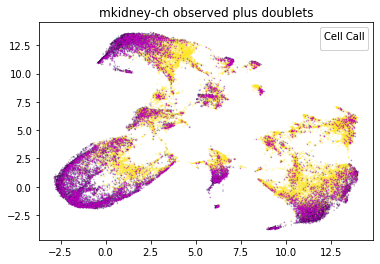

In [99]:
#check pretrainied embedding

encoding = tf.convert_to_tensor(encoder(X))
proj_plain = um.UMAP(n_neighbors=7).fit_transform(encoding)


fig, ax = plt.subplots()
col = np.concatenate([true, np.ones([P.shape[0]])+1])
scatter = ax.scatter(proj2[:,0],proj2[:,1], c=col, s=0.1, alpha=0.5)
scatter = ax.scatter(proj2[col==1,0],proj2[col==1,1], c='m', s=0.2, alpha=0.5)
legend = ax.legend(*scatter.legend_elements(), title= 'Cell Call')
plt.title(data_name + ' origional UMAP')
ax.add_artist(legend)
plt.title(data_name + ' observed plus doublets')
plt.show()

In [115]:
proj_plain_d = um.UMAP(n_neighbors=7).fit_transform(np.array(encoding)[(col!=0),:])


In [149]:
vae_layers = list(itertools.chain(encoder.layers, decoder.layers))
    
vae_eps = np.ones([51]).astype(int)
btch_eps = np.ones([50]).astype(int)
vae_eps[0] = 10
btch_eps[0] = 10

print('start')
for layer in discriminator.layers:
    layer.trainable = False

#initialize latent space with no influence of batches
vae.compile(optimizer = tf.optimizers.Adam(learning_rate=1e-5),
              loss=[nll,'binary_crossentropy'],loss_weights=[0.1,0])

hist = vae.fit(x=X,
               y=[X,Y],
               epochs=vae_eps[0], 
               use_multiprocessing=True)

hist_list = [hist]



start
Epoch 1/10
1324/1324 [==============================] - 7s 4ms/step - loss: 16868.5406 - decoder_loss: 168685.3957 - discriminator_loss: 1.2848
Epoch 2/10
1324/1324 [==============================] - 6s 4ms/step - loss: 12997.2245 - decoder_loss: 129972.2668 - discriminator_loss: 1.4573
Epoch 3/10
1324/1324 [==============================] - 6s 4ms/step - loss: 11731.6100 - decoder_loss: 117316.1091 - discriminator_loss: 1.4565
Epoch 4/10
1324/1324 [==============================] - 6s 4ms/step - loss: 10879.7449 - decoder_loss: 108797.4679 - discriminator_loss: 1.4177
Epoch 5/10
1324/1324 [==============================] - 6s 4ms/step - loss: 10302.8343 - decoder_loss: 103028.3378 - discriminator_loss: 1.3872
Epoch 6/10
1324/1324 [==============================] - 6s 4ms/step - loss: 9765.4423 - decoder_loss: 97654.4145 - discriminator_loss: 1.3430
Epoch 7/10
1324/1324 [==============================] - 6s 4ms/step - loss: 9290.3624 - decoder_loss: 92903.6405 - discriminator_los

/usr/local/lib/python3.6/dist-packages/matplotlib/collections.py:1039: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


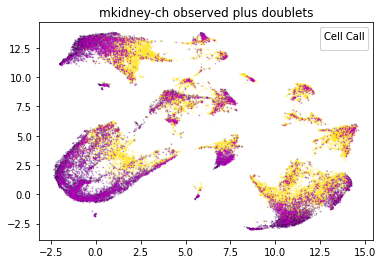

In [118]:
#check pretrainied embedding

encoding = tf.convert_to_tensor(encoder(X))
proj2 = um.UMAP(n_neighbors=7).fit_transform(encoding)

fig, ax = plt.subplots()
col = np.concatenate([true, np.ones([P.shape[0]])+1])
scatter = ax.scatter(proj2[:,0],proj2[:,1], c=col, s=0.1, alpha=0.5)
scatter = ax.scatter(proj2[col==1,0],proj2[col==1,1], c='m', s=0.2, alpha=0.5)
legend = ax.legend(*scatter.legend_elements(), title= 'Cell Call')
plt.title(data_name + ' origional UMAP')
ax.add_artist(legend)
plt.title(data_name + ' observed plus doublets')
plt.show()

In [119]:
for i in range(len(btch_eps)):
    print(i)
    print('DISCRIMINATOR')
    #train batch classifier, freeze VAE
    for layer in discriminator.layers:
        layer.trainable = True

    for layer in vae_layers:
        layer.trainable = False

    vae.compile(optimizer = tf.optimizers.Adam(learning_rate=1e-5),
                  loss=[nll,'binary_crossentropy'],loss_weights=[0,1])

    hist = vae.fit(x=X,
                   y=[X,Y],
                   epochs=btch_eps[i], 
                   use_multiprocessing=True)

    hist_list.append(hist)

    #train VAE, freeze batch classifier
    print('VAE')
    for layer in discriminator.layers:
        layer.trainable = False

    for layer in vae_layers:
        layer.trainable = True

    vae.compile(optimizer = tf.optimizers.Adam(learning_rate=1e-5),
                  loss=[nll,'binary_crossentropy'],loss_weights=[0.1,-1000])


    hist = vae.fit(x=X,
                   y=[X,Y],
                   epochs=vae_eps[i+1], 
                   use_multiprocessing=True)

    hist_list.append(hist)


0
DISCRIMINATOR
Epoch 1/10
1324/1324 [==============================] - 4s 2ms/step - loss: 1.1009 - decoder_loss: 60899.1586 - discriminator_loss: 1.1009
Epoch 2/10
1324/1324 [==============================] - 2s 2ms/step - loss: 1.0329 - decoder_loss: 60687.0834 - discriminator_loss: 1.0329
Epoch 3/10
1324/1324 [==============================] - 2s 2ms/step - loss: 0.9541 - decoder_loss: 60912.8421 - discriminator_loss: 0.9541
Epoch 4/10
1324/1324 [==============================] - 2s 2ms/step - loss: 0.9007 - decoder_loss: 60675.0326 - discriminator_loss: 0.9007
Epoch 5/10
1324/1324 [==============================] - 2s 2ms/step - loss: 0.8509 - decoder_loss: 60900.4747 - discriminator_loss: 0.8509
Epoch 6/10
1324/1324 [==============================] - 2s 2ms/step - loss: 0.8109 - decoder_loss: 60796.0933 - discriminator_loss: 0.8109
Epoch 7/10
1324/1324 [==============================] - 2s 2ms/step - loss: 0.7910 - decoder_loss: 61059.5715 - discriminator_loss: 0.7910
Epoch 8/10






























































[10 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42
 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66
 67 68 69 70 71 72 73 74 75 76 77 78 79]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

<Figure size 5400x1800 with 0 Axes>

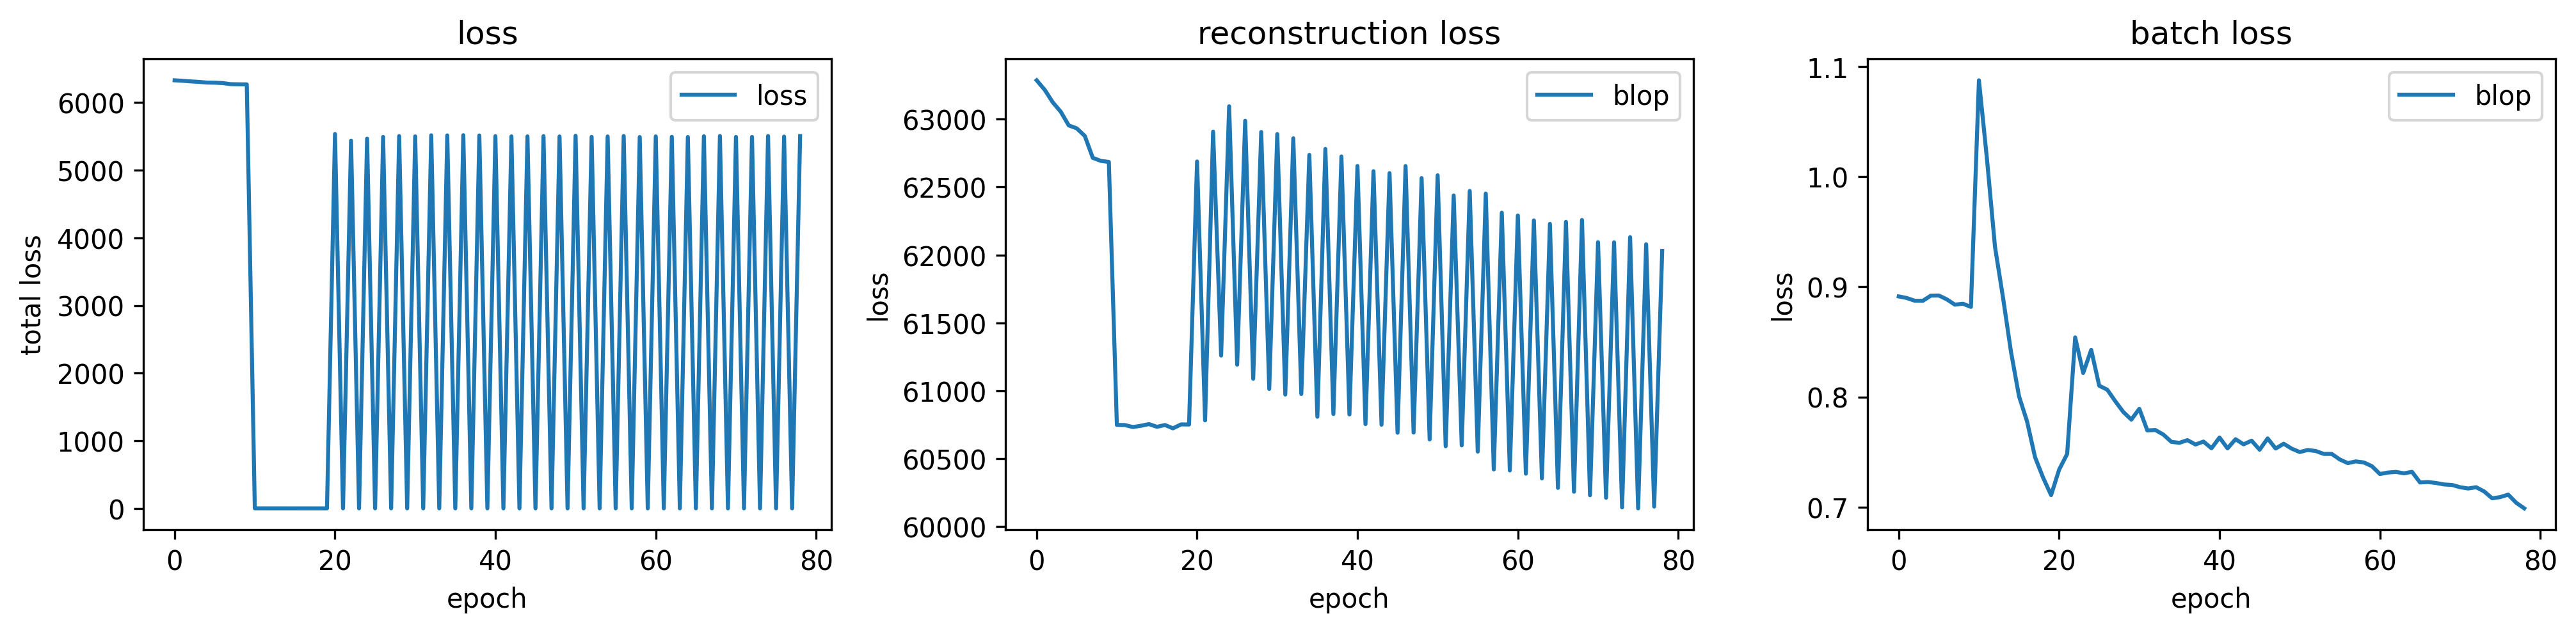

In [120]:
plt_adversarial_loss(hist_list, 'blop', 'blop', m_eps=False)

/usr/local/lib/python3.6/dist-packages/matplotlib/collections.py:1039: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


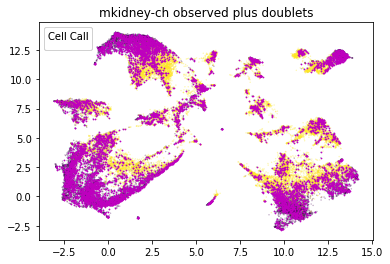

In [121]:
#check pretrainied embedding

encoding = tf.convert_to_tensor(encoder(X))
proj2 = um.UMAP(n_neighbors=7).fit_transform(encoding)

fig, ax = plt.subplots()
col = np.concatenate([true, np.ones([P.shape[0]])+1])
scatter = ax.scatter(proj2[:,0],proj2[:,1], c=col, s=0.1, alpha=0.5)
scatter = ax.scatter(proj2[col==1,0],proj2[col==1,1], c='m', s=0.5, alpha=1)
legend = ax.legend(*scatter.legend_elements(), title= 'Cell Call')
plt.title(data_name + ' origional UMAP')
ax.add_artist(legend)
plt.title(data_name + ' observed plus doublets')
plt.show()

In [122]:
z_all   = np.array(tf.convert_to_tensor(encoder(X)))
z_real  = z_all[:U.shape[0],:]
z_sim   = z_all[U.shape[0]:,:]
preds   = tf.convert_to_tensor(discriminator(z_all))

<Figure size 432x288 with 0 Axes>

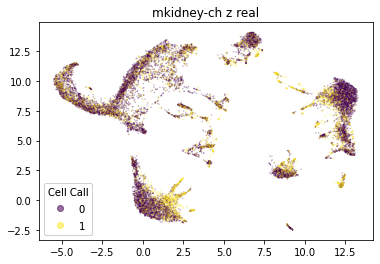

In [65]:
if(projections):
    plt.figure(0)
    proj5 = um.UMAP(n_neighbors=7).fit_transform(z_real)
    fig, ax = plt.subplots()
    col = true
    scatter = ax.scatter(proj5[:,0],proj5[:,1], c=col, s=0.1, alpha=0.5)
    legend = ax.legend(*scatter.legend_elements(), title="Cell Call")
    ax.add_artist(legend)
    plt.title(data_name + ' z real')
    if(save_figs):
        plt.savefig(save_path + '_UMAP_z_real.png')
    plt.show()
     

<Figure size 432x288 with 0 Axes>

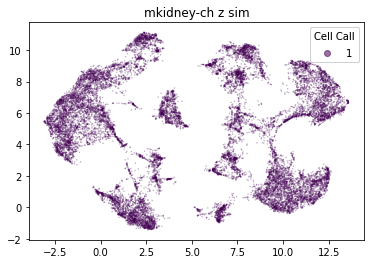

In [66]:
if(projections):
    plt.figure(1)
    proj6 = um.UMAP(n_neighbors=7).fit_transform(z_sim)
    fig, ax = plt.subplots()
    col = np.ones([P.shape[0]])
    scatter = ax.scatter(proj6[:,0],proj6[:,1], c=col, s=0.1, alpha=0.5)
    legend = ax.legend(*scatter.legend_elements(), title="Cell Call")
    ax.add_artist(legend)
    plt.title(data_name + ' z sim')
    if(save_figs):
        plt.savefig(save_path + '_UMAP_z_sim.png')
    plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/collections.py:1039: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


<Figure size 432x288 with 0 Axes>

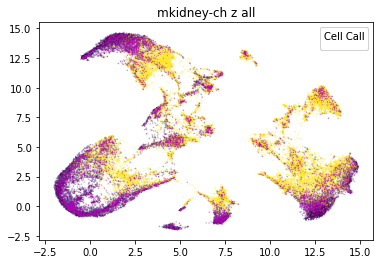

In [68]:
if(projections):
    plt.figure(2)
    proj7 = um.UMAP(n_neighbors=7).fit_transform(z_all)
    fig, ax = plt.subplots()
    col = np.concatenate([true, np.ones([P.shape[0]])+1])
    scatter = ax.scatter(proj7[:,0],proj7[:,1], c=col, s=0.1, alpha=0.5)
    scatter = ax.scatter(proj7[col==1,0],proj7[col==1,1], c='m', s=0.1, alpha=0.5)
    legend = ax.legend(*scatter.legend_elements(), title="Cell Call")
    ax.add_artist(legend)
    plt.title(data_name + ' z all')
    if(save_figs):
        plt.savefig(save_path + '_UMAP_z_all.png')
    plt.show()
    


<Figure size 432x288 with 0 Axes>

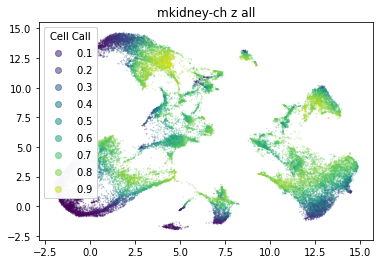

In [69]:
if(projections):
    plt.figure(2)
    fig, ax = plt.subplots()
    col = preds
    scatter = ax.scatter(proj7[:,0],proj7[:,1], c=col, s=0.1, alpha=0.5)
    legend = ax.legend(*scatter.legend_elements(), title="Cell Call")
    ax.add_artist(legend)
    plt.title(data_name + ' z all')
    if(save_figs):
        plt.savefig(save_path + '_UMAP_z_all.png')
    plt.show()

In [70]:
col = np.concatenate([true, np.ones([P.shape[0]])+1])

X[(col!=0),:].shape

(29080, 2000)

In [71]:
X.shape

(42358, 2000)

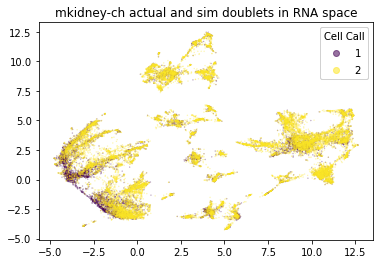

In [72]:
col = np.concatenate([true, np.ones([P.shape[0]])+1])

if(projections):
    proj2 = um.UMAP(n_neighbors=7).fit_transform(X[(col!=0),:])
    fig, ax = plt.subplots()
    col = col[(col!=0)]
    scatter = ax.scatter(proj2[:,0],proj2[:,1], c=col, s=0.1, alpha=.5)
    legend = ax.legend(*scatter.legend_elements(), title="Cell Call")
    ax.add_artist(legend)
    plt.title(data_name + ' actual and sim doublets in RNA space')
    plt.show()

<Figure size 432x288 with 0 Axes>

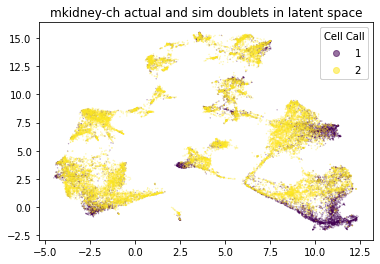

In [123]:
col = np.concatenate([true, np.ones([P.shape[0]])+1])
if(projections):
    plt.figure(2)
    proj7 = um.UMAP(n_neighbors=7).fit_transform(z_all[(col!=0),:])
    fig, ax = plt.subplots()
    col = col[(col!=0)]
    scatter = ax.scatter(proj7[:,0],proj7[:,1], c=col, s=0.1, alpha=0.5)
    legend = ax.legend(*scatter.legend_elements(), title="Cell Call")
    ax.add_artist(legend)
    plt.title(data_name + ' actual and sim doublets in latent space')
    #if(save_figs):
    #    plt.savefig(save_path + '_UMAP_z_all.png')
    plt.show()

<Figure size 432x288 with 0 Axes>

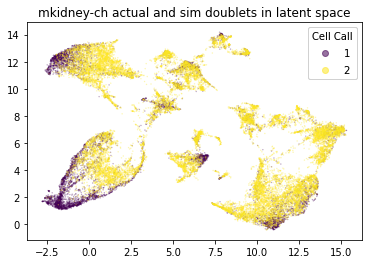

In [116]:
col = np.concatenate([true, np.ones([P.shape[0]])+1])
if(projections):
    plt.figure(2)
    fig, ax = plt.subplots()
    col = col[(col!=0)]
    scatter = ax.scatter(proj_plain_d[:,0],proj_plain_d[:,1], c=col, s=0.1, alpha=0.5)
    legend = ax.legend(*scatter.legend_elements(), title="Cell Call")
    ax.add_artist(legend)
    plt.title(data_name + ' actual and sim doublets in latent space')
    #if(save_figs):
    #    plt.savefig(save_path + '_UMAP_z_all.png')
    plt.show()

In [74]:
num_pca = 5
pca = PCA(n_components=num_pca)
PCs = pca.fit_transform(X)

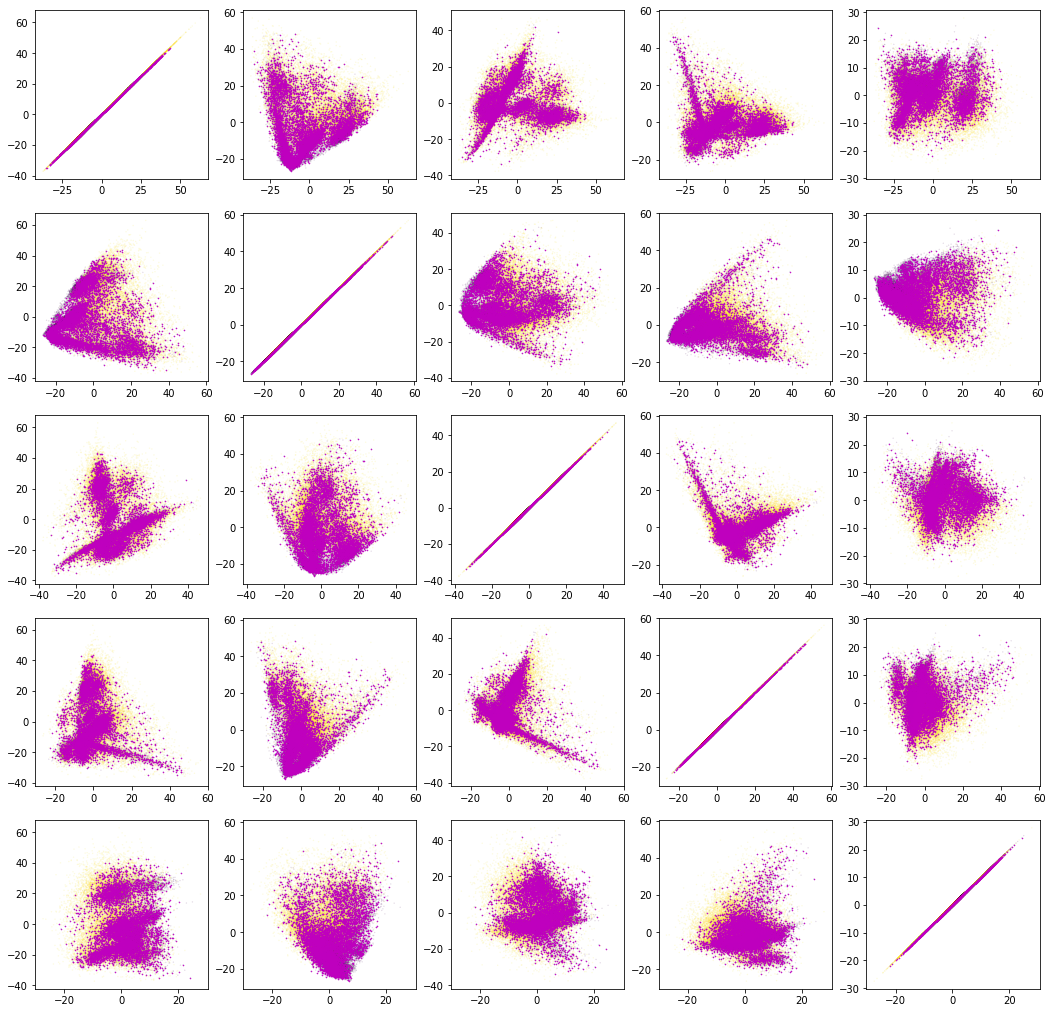

In [75]:
fig, ax = plt.subplots(nrows=num_pca, ncols=num_pca, figsize=(18, 18))
col = np.concatenate([true, np.ones([P.shape[0]])+1])

for i in range(num_pca):
    for j in range(num_pca):
        
        x = PCs[:,i]
        y = PCs[:,j]

        ax[i,j].scatter(x, y, c=col, s=0.1, alpha=0.2)
        ax[i,j].scatter(x[col==1], y[col==1], c='m', s=0.3, alpha=1)

In [76]:
PCs = pca.fit_transform(z_all)

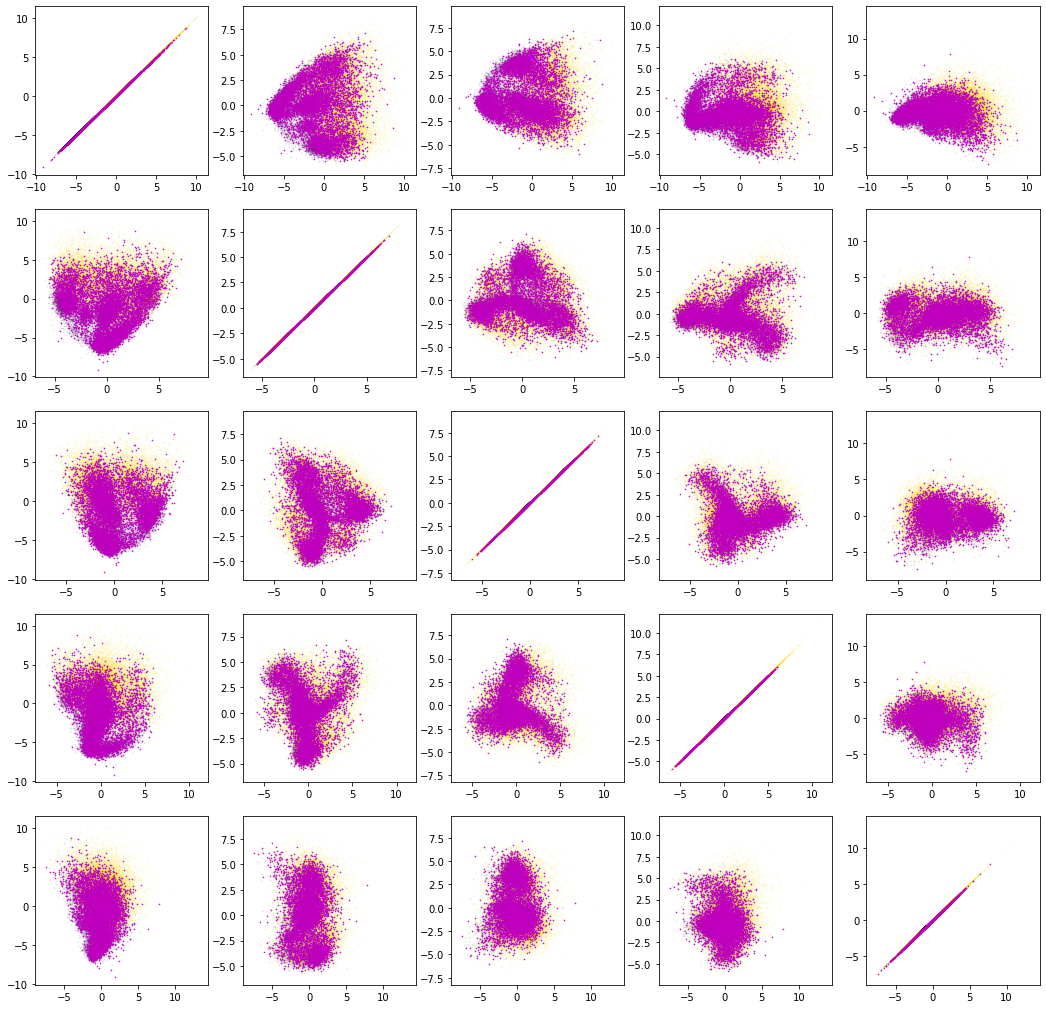

In [77]:
fig, ax = plt.subplots(nrows=num_pca, ncols=num_pca, figsize=(18, 18))
col = np.concatenate([true, np.ones([P.shape[0]])+1])

for i in range(num_pca):
    for j in range(num_pca):
        
        x = PCs[:,i]
        y = PCs[:,j]

        ax[i,j].scatter(x, y, c=col, s=0.1, alpha=0.2)
        ax[i,j].scatter(x[col==1], y[col==1], c='m', s=0.3, alpha=1)

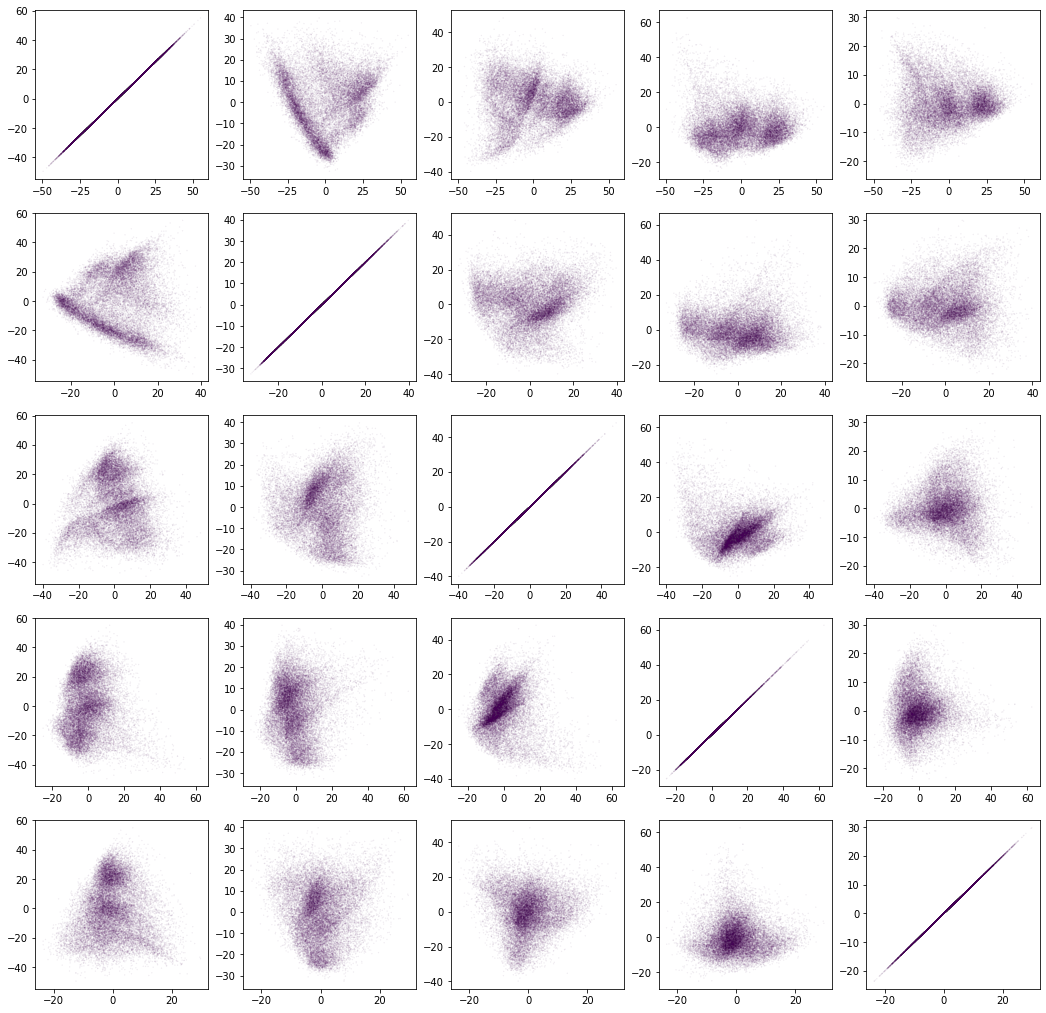

In [78]:
fig, ax = plt.subplots(nrows=num_pca, ncols=num_pca, figsize=(18, 18))
col = np.concatenate([true, np.ones([P.shape[0]])+1])

PCs = pca.fit_transform(X[Y==1,:])
col = col[Y==1]

for i in range(num_pca):
    for j in range(num_pca):
        
        x = PCs[:,i]
        y = PCs[:,j]

        ax[i,j].scatter(x, y, c=col, s=0.1, alpha=0.1)

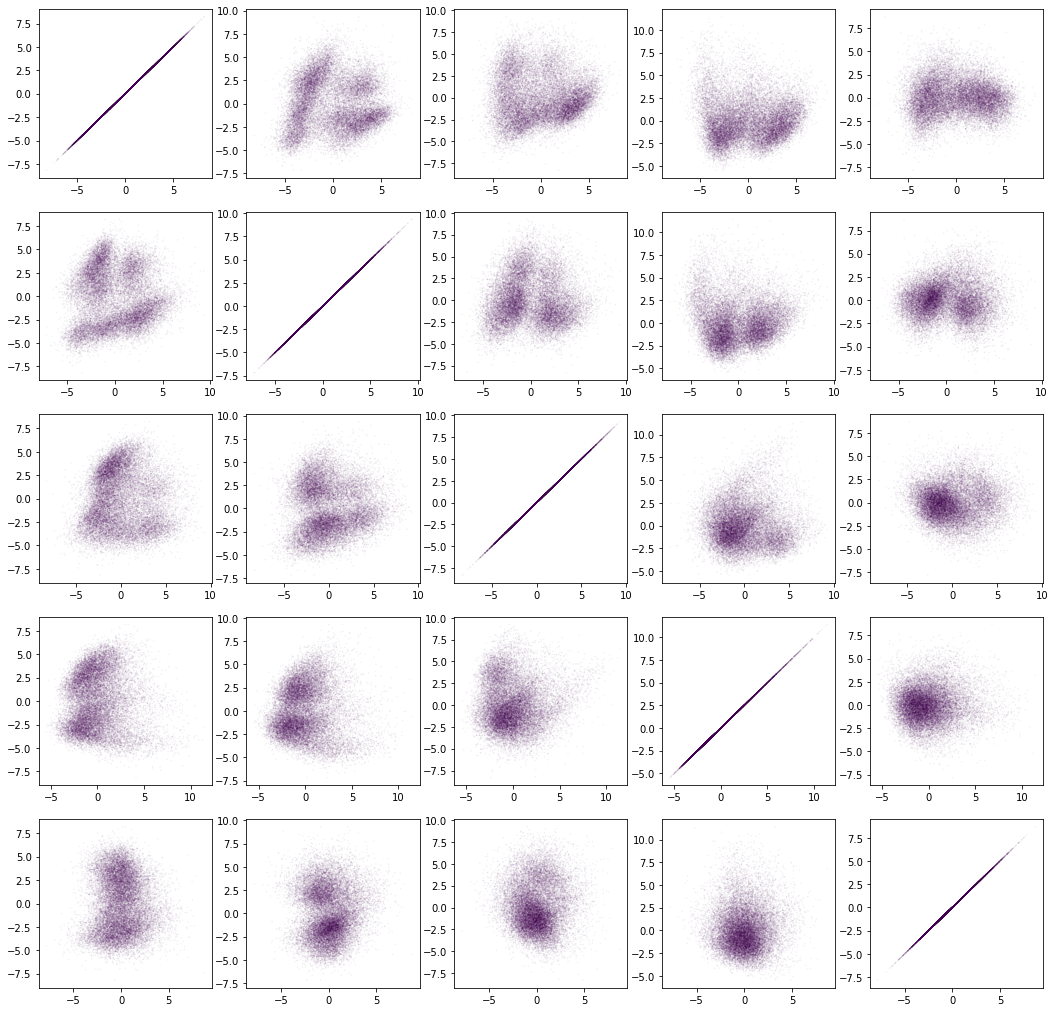

In [79]:
fig, ax = plt.subplots(nrows=num_pca, ncols=num_pca, figsize=(18, 18))
col = np.concatenate([true, np.ones([P.shape[0]])+1])

PCs = pca.fit_transform(z_all[Y==1,:])
col = col[Y==1]

for i in range(num_pca):
    for j in range(num_pca):
        
        x = PCs[:,i]
        y = PCs[:,j]

        ax[i,j].scatter(x, y, c=col, s=0.1, alpha=0.1)

<Figure size 432x288 with 0 Axes>

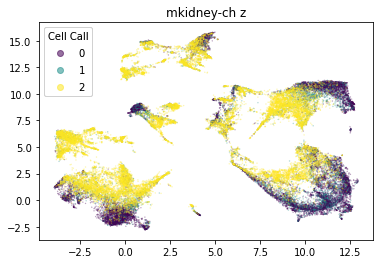

In [124]:




#z2 = np.array(tf.convert_to_tensor(generator(P)))
#z = np.vstack([z,z2])



U = z_all[Y==0,:]
P = z_all[Y==1,:]

if(projections):
    plt.figure(0)
    proj5 = um.UMAP(n_neighbors=7).fit_transform(z_all)
    fig, ax = plt.subplots()
    #col = np.concatenate([true, np.ones([P.shape[0]])+1])
    if(simulate_doubs):
        col = np.concatenate([true, np.ones([P.shape[0]])+1])
    else:
        col = Y
    scatter = ax.scatter(proj5[:,0],proj5[:,1], c=col, s=0.1, alpha=0.5)
    legend = ax.legend(*scatter.legend_elements(), title="Cell Call")
    ax.add_artist(legend)
    plt.title(data_name + ' z')
    if(save_figs):
        plt.savefig(save_path + '_UMAP_z.png')
    plt.show()
     



    

In [125]:
#downsample the simulated doublets
#ind = np.arange(P.shape[0])
#np.random.shuffle(ind)
#num = int(P.shape[0] * (1/10))

#P = P[ind[:num],:]


1/10 itterations

2/10 itterations

3/10 itterations

4/10 itterations

5/10 itterations

6/10 itterations

7/10 itterations

8/10 itterations

9/10 itterations

10/10 itterations
[0.45139267 0.96062406 0.40341995 ... 0.22998229 0.46818394 0.49892329]
results after N = 10.0
(0.6791783341062855, 0.5886268290630106, 0.5887438791770104)


<Figure size 432x288 with 0 Axes>

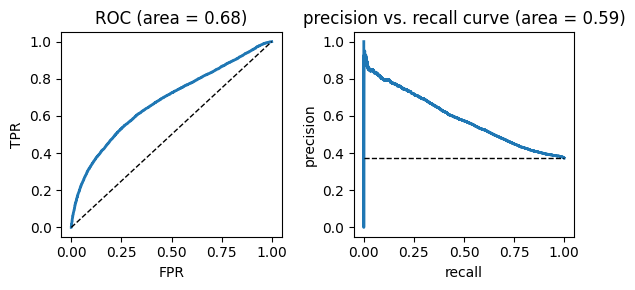

In [126]:
#if(classification_method == 'PU'):
if (True):
    #PU BAGGING
    random_state = 12883823
    rkf = RepeatedKFold(n_splits=k, n_repeats=N, random_state=random_state)

    preds= np.zeros([U.shape[0]])
    preds_on_P = np.zeros([P.shape[0]])
    hists = np.zeros([N*k, cls_eps])
    i = 0
    for test, train in rkf.split(U):
        i = i + 1
        print('')
        print(str(i) + '/' + str(N*k) + ' itterations')

        X = np.vstack([U[train,:], P])
        Y = np.concatenate([np.zeros([len(train)]),
                           np.ones([P.shape[0]])])

        x = U[test,:]
        y = true.astype(int)[test]

        #DEFINE MODEL
        classifier = define_classifier(enc_sze)

        #shuffle training data
        ind = np.arange(X.shape[0])
        np.random.shuffle(ind)

        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.01, patience=5)
        hist = classifier.fit(x=X[ind,:], y=Y[ind], epochs=cls_eps, verbose=False, callbacks=[callback])#, validation_data=(x,y))

        hists[i-1,:len(hist.history['loss'])]= hist.history['loss']

        #if (i==1):
            #vals = hist.history['val_loss']
        #else:
            #vals = np.vstack([vals, hist.history['val_loss']])

        preds[test] = preds[test] + np.array(classifier(x)).flatten()
        preds_on_P = preds_on_P + np.array(classifier(P)).flatten()

        if((i)%k == 0):

            new_preds = preds / ((i/k)*(k-1))

            if( i > k ):
                change = np.max(np.abs(new_preds - old_preds))
                if(change <= 0.01):
                    print('Early Stopping')
                    break

            print(new_preds)
            plt.figure(1000 + i)
            res = get_dbl_metrics(true, new_preds)
            print('results after N = ' + str(i/N))
            print(res)
            plt.show()
            old_preds = new_preds

    preds = preds / ((i/k)*(k-1))
    preds_on_P = preds_on_P / ((i/k)*(k-1))


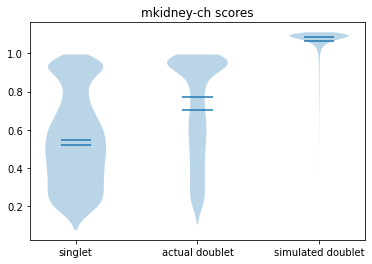

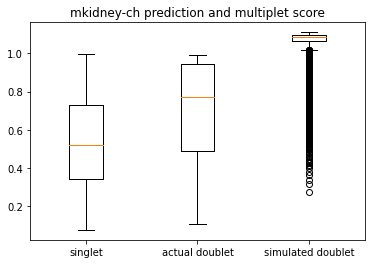

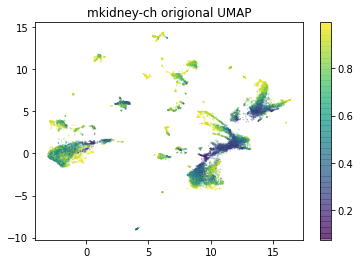

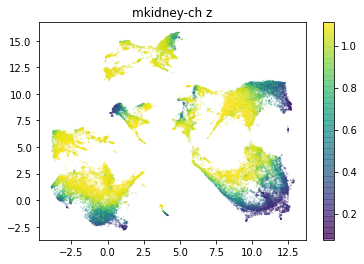

<Figure size 432x288 with 0 Axes>

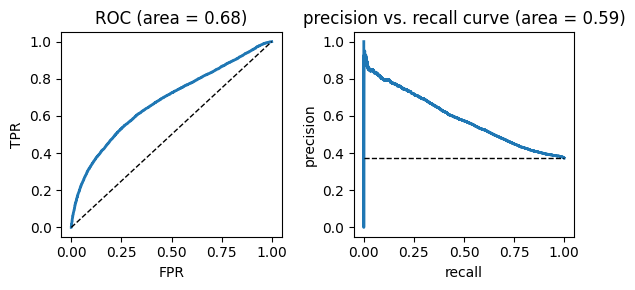

In [127]:
#RESULTS
if(simulate_doubs):
    preds_sing = preds[true==False]
    preds_doub_test = preds[true]
    preds_doub_train = preds_on_P
    labs = ['singlet', 'actual doublet', 'simulated doublet']
    cols = np.concatenate([preds, preds_on_P])
else:
    print('concat')
    preds = np.concatenate([preds, preds_on_P])

    ind = np.arange(len(preds))
    ind = np.concatenate([ind[true==False], ind[true==True]])
    ind = np.argsort(ind)

    preds = preds[ind]

    preds_sing = preds[true==0]
    preds_doub_test = preds[ind4[int(len(ind4)/2):]]
    preds_doub_train = preds[ind4[:int(len(ind4)/2)]]
    labs = ['singlet', 'doublet test', 'doublet train']
    cols = preds

    ind3 = np.concatenate([np.arange(dat_c.shape[0])[true==False], ind2[int(len(ind2)/2):]])
    plt.figure(1000)
    res = get_dbl_metrics(true[ind3], preds[ind3])
    if(save_figs):
        plt.savefig(save_path + '_scores_ROC_PR_curves_TEST.png')
    plt.show()

    plt.figure(20)
    if(save_figs):
        hm_pr = pd.DataFrame(np.array(res).T, index=['AUROC', 'AUPRC', 'AP']).T
        hm_pr.to_csv(save_path + '_scores_ROC_PR_area_TEST.csv') 
    plt.show()

plt.figure(1)
plt.violinplot([preds_sing, preds_doub_test, preds_doub_train], [1,2,3],
              showmeans=True, showextrema=False, showmedians=True)
plt.xticks(ticks = [1,2,3], labels=labs)
plt.title(data_name + ' scores')
if(save_figs):
    plt.savefig(save_path + '_scores_violinplot.png')
plt.show()

plt.figure(2)
plt.boxplot([preds_sing, preds_doub_test, preds_doub_train])
plt.xticks(ticks = [1,2,3], labels=labs)
plt.title(data_name + ' prediction and multiplet score')
if(save_figs):
    plt.savefig(save_path + '_scores_boxplot.png')
plt.show()

plt.figure(3)
plt.scatter(proj[:,0],proj[:,1], c=preds, s=0.1, alpha=0.5)
plt.colorbar()
plt.title(data_name + ' origional UMAP')
if(save_figs):
    plt.savefig(save_path + '_scores_UMAP.png') 
plt.show()

plt.figure(5)
plt.scatter(proj5[:,0],proj5[:,1], c=cols, s=0.1, alpha=0.5)
plt.colorbar()
plt.title(data_name + ' z')
if(save_figs):
    plt.savefig(save_path + '_scores_z_UMAP.png')
plt.show()

#plot library size onto z
#plt.figure(25)
#plt.scatter(proj5[:,0],proj5[:,1], c=np.log1p(lib_sizes), s=0.1, alpha=0.5)
#plt.colorbar()
#plt.title(data_name + ' z lib size')
#if(save_figs):
#    plt.savefig(save_path + '_libsze_z_UMAP.png')
#plt.show()

if(save_figs):
    ano.to_csv(save_path + '_scores.csv') 

plt.figure(4)
res = get_dbl_metrics(true, preds)
if(save_figs):
    plt.savefig(save_path + '_scores_ROC_PR_curves_ALL.png')

hm_pr = pd.DataFrame(np.array(res).T, index=['AUROC', 'AUPRC', 'AP']).T
hm_pr.to_csv(save_path + '_scores_ROC_PR_area_ALL.csv') 

if((classification_method=='PU') | (classification_method=='classifier')):
    plt.figure(94)
    x = np.arange(len(hists[0]))
    m = hists.mean(axis=0)
    std = np.std(hists, axis=0)
    plt.plot(x,m)
    plt.fill_between(x, m-std, m+std, alpha=0.3)
    plt.title(data_name + ' Classification Loss')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    if(save_figs):
        plt.savefig(save_path + '_classification_loss.png')
    plt.show()

if(False):
    plt.figure(79)
    x = np.arange(len(vals[0]))
    m = vals.mean(axis=0)
    std = np.std(vals, axis=0)
    plt.plot(x,m)
    plt.fill_between(x, m-std, m+std, alpha=0.3)
    plt.title(data_name + ' Validation Loss')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    if(save_figs):
        plt.savefig(save_path + '_validation_loss.png')
    plt.show()

